In [1]:
import sys
sys.path.append('../../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set
import matplotlib.pyplot as plt
from matplotlib import rc


In [2]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

M = 1e3  # Big M

# Define temporal scales
scales = TemporalScale(discretization_list=[2, _exec_scenarios, _time_intervals])

# loc5_backlog_penalty_factor = pandas.DataFrame(data={'com1_sold':[1]*4 + [1]*20})
# loc4_varying_factor = pandas.DataFrame(data={'com1_process': [1]*6 + [0]*18})

In [3]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================
com1_pur = Resource(name='com1_pur', cons_max=125, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [4]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_process_capacity = 150

com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1}, capex=0.01, vopex=0.01, prod_min=125, label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01, vopex=0.01, prod_min=com1_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=com1_process_capacity, capex=100, vopex=1, store_min=0.01, store_max= 20, prod_min=com1_process_capacity, label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)
com1_store20 = Process(name='com1_store20', prod_max=com1_process_capacity, capex=200, vopex=2, store_min=0.01,store_max= 40, prod_min=com1_process_capacity, label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)
com1_store50 = Process(name='com1_store50', prod_max=com1_process_capacity, capex=500, vopex=5, store_min=0.01, store_max= 100, prod_min=com1_process_capacity, label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 7')

In [5]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

In [6]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

multiplier = 1

trans_min = 0.001

truck_cap12 = 70 * multiplier
truck_cap13 = 50 * multiplier
truck_cap24 = 50 * multiplier
truck_cap25 = 30 * multiplier
truck_cap34 = 20 * multiplier
truck_cap45 = 100 * multiplier
truck_cap47 = 40 * multiplier
truck_cap64 = 50 * multiplier
truck_cap75 = 40 * multiplier

truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5, vopex=0.05, trans_min=trans_min, speed=20)
truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=trans_min, speed=20)

truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3, vopex=0.03, trans_min=trans_min, speed=20)
truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=trans_min, speed=20)

truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5, vopex=0.05, trans_min=trans_min, speed=20)
truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=trans_min, speed=20)

truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3, vopex=0.03, trans_min=trans_min, speed=20)
truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=trans_min, speed=20)

truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2, vopex=0.02, trans_min=trans_min, speed=20)
truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=trans_min, speed=20)

truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1, vopex=0.1, trans_min=trans_min, speed=20)
truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=trans_min, speed=20)

truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4, vopex=0.04, trans_min=trans_min, speed=20)
truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=trans_min, speed=20)

truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5, vopex=0.05, trans_min=trans_min, speed=20)
truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=trans_min, speed=20)

truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4, vopex=0.04, trans_min=trans_min, speed=20)
truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=trans_min, speed=20)

In [7]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================

# transport_matrix = [
#     [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
#     [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
#     [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
#     [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
#     [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
#     [[], [], [], [truck50_64], [], [], []],  # source: location 6
#     [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
# ]

# transport_matrix = [
#     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
#     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
#     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
#     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
#     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
#     [[], [], [], [truck64], [], [], []],  # source: location 6
#     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
# ]

transport_matrix = [
    [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    [[], [], [], [truck24], [truck25], [], []],  # source: location 2
    [[], [], [], [truck34], [], [], []],  # source: location 3
    [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
    [[], [], [], [], [], [], []],  # source: location 5
    [[], [], [], [truck64], [], [], []],  # source: location 6
    [[], [], [], [], [truck75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)


In [8]:
daily_demand = 100
demand_penalty = 75
backlog_penalty = 50

demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
backlog_penalty_dict = {i:{com1_sold: backlog_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

backlog_zero = {'loc5':{'com1_sold': 43}} # (Age, Qty)

scenario = Scenario(name='scenario_baseline', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1, backlog_penalty_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, backlog_penalty=backlog_penalty_dict, label='Scenario with perfect information')

In [9]:
scenario.demand_penalty

{'loc1': {'com1_sold': 0},
 'loc2': {'com1_sold': 0},
 'loc3': {'com1_sold': 0},
 'loc4': {'com1_sold': 0},
 'loc5': {'com1_sold': 75},
 'loc6': {'com1_sold': 0},
 'loc7': {'com1_sold': 0}}

In [10]:
scenario.backlog_penalty

{'loc1': {'com1_sold': 0},
 'loc2': {'com1_sold': 0},
 'loc3': {'com1_sold': 0},
 'loc4': {'com1_sold': 0},
 'loc5': {'com1_sold': 50},
 'loc6': {'com1_sold': 0},
 'loc7': {'com1_sold': 0}}

In [11]:
problem_mincost = formulate(scenario=scenario,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.BACKLOG, Constraints.NETWORK, Constraints.PRESERVE_NETWORK},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY, backlog_zero=backlog_zero)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint preserve capacity facility
constraint preserve capacity transport


In [12]:
results_mincost = solve(scenario=scenario, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1128353 rows, 2739715 columns and 1533346 nonzeros
Model fingerprint: 0xd337e212
Variable types: 2738469 continuous, 1246 integer (1246 binary)
Coefficient statistics:
  Matrix range     [1e-03, 5e+02]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+02]
Presolve removed 1053924 rows and 2662472 columns
Presolve time: 0.26s
Presolved: 74429 rows, 77243 columns, 246713 nonzeros
Variable types: 77099 continuous, 144 integer (130 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...
Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.111425e+06, 11868 iterations, 0.46 seco

In [13]:
problem_mincost.constraint_backlog_cost_network.pprint()

constraint_backlog_cost_network : Total backlog penalty cost for the network
    Size=2, Index=resources_demand*{0, 1}, Active=True
    Key              : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                              : Upper : Active
    ('com1_sold', 0) :   0.0 : Demand_backlog_cost_network[com1_sold,0] - (Demand_backlog_cost_location[loc1,com1_sold,0] + Demand_backlog_cost_location[loc2,com1_sold,0] + Demand_backlog_cost_location[loc3,com1_sold,0] + Demand_backlog_cost_location[loc4,com1_sold,0] + Demand_backlog_cost_location[loc5,com1_sold,0] + Demand_backlog_cost_location[loc6,com1_sold,0] + Demand_backlog_cost_location[loc7,com1_sold,0]) :   0.0 :   True


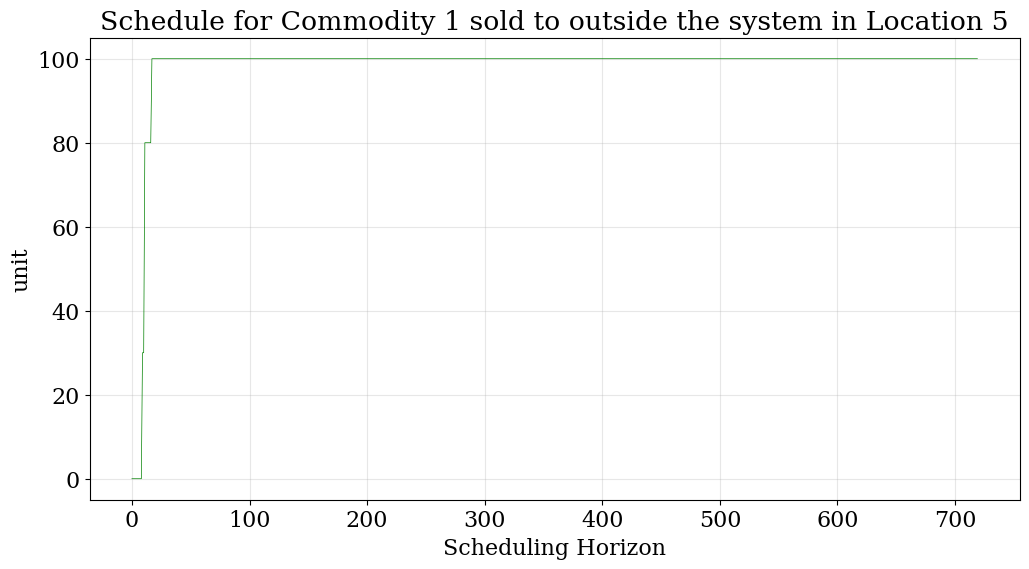

In [14]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

In [15]:
print(*[(k,v) for k,v in results_mincost.output['Cap_P'].items() if v], sep='\n')

(('loc1', 'com1_loc1_send', 0), 150.0)
(('loc1', 'com1_loc1_send', 1), 150.0)
(('loc1', 'com1_process', 0), 150.0)
(('loc1', 'com1_process', 1), 150.0)
(('loc1', 'procure com1', 0), 125.0)
(('loc1', 'procure com1', 1), 125.0)
(('loc2', 'com1_loc2_send', 0), 150.0)
(('loc2', 'com1_loc2_send', 1), 150.0)
(('loc2', 'com1_process', 0), 150.0)
(('loc2', 'com1_process', 1), 150.0)
(('loc2', 'com1_receive_loc1', 0), 150.0)
(('loc2', 'com1_receive_loc1', 1), 150.0)
(('loc3', 'com1_loc3_send', 0), 150.0)
(('loc3', 'com1_loc3_send', 1), 150.0)
(('loc3', 'com1_process', 0), 150.0)
(('loc3', 'com1_process', 1), 150.0)
(('loc3', 'com1_receive_loc1', 0), 150.0)
(('loc3', 'com1_receive_loc1', 1), 150.0)
(('loc4', 'com1_loc4_send', 0), 150.0)
(('loc4', 'com1_loc4_send', 1), 150.0)
(('loc4', 'com1_process', 0), 150.0)
(('loc4', 'com1_process', 1), 150.0)
(('loc4', 'com1_receive_loc2', 0), 150.0)
(('loc4', 'com1_receive_loc2', 1), 150.0)
(('loc4', 'com1_receive_loc3', 0), 150.0)
(('loc4', 'com1_receive_

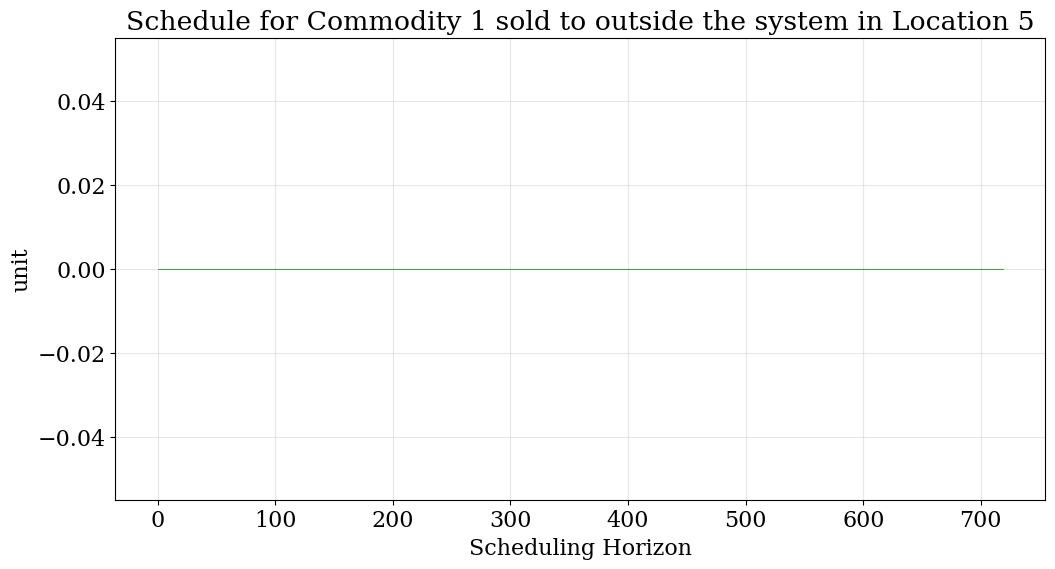

In [16]:
plot_results.schedule(results=results_mincost, y_axis='S_backlog', component='com1_sold', location='loc5', color='green')

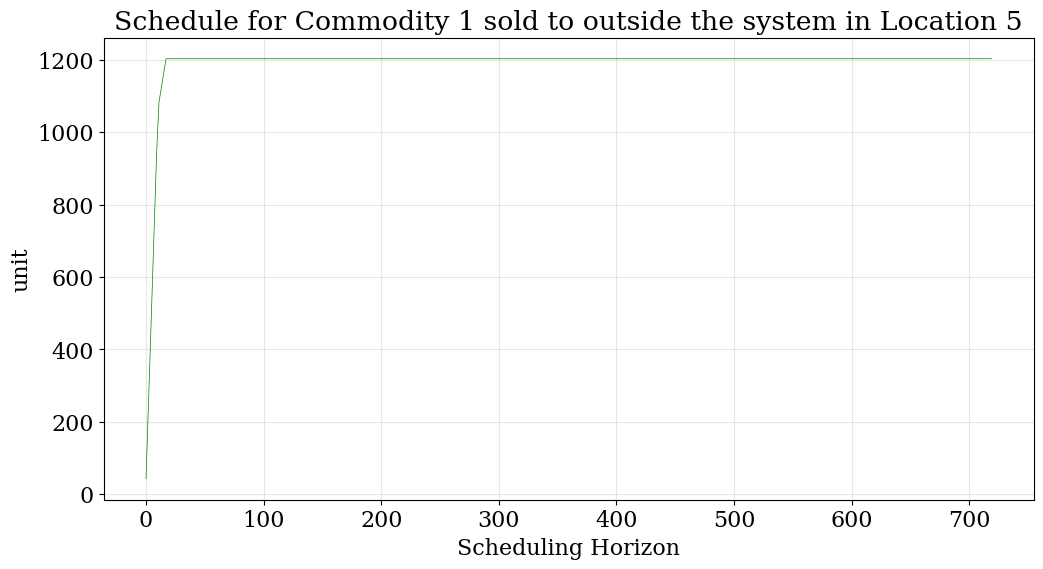

In [17]:
plot_results.schedule(results=results_mincost, y_axis='Demand_backlog', component='com1_sold', location='loc5', color='green')

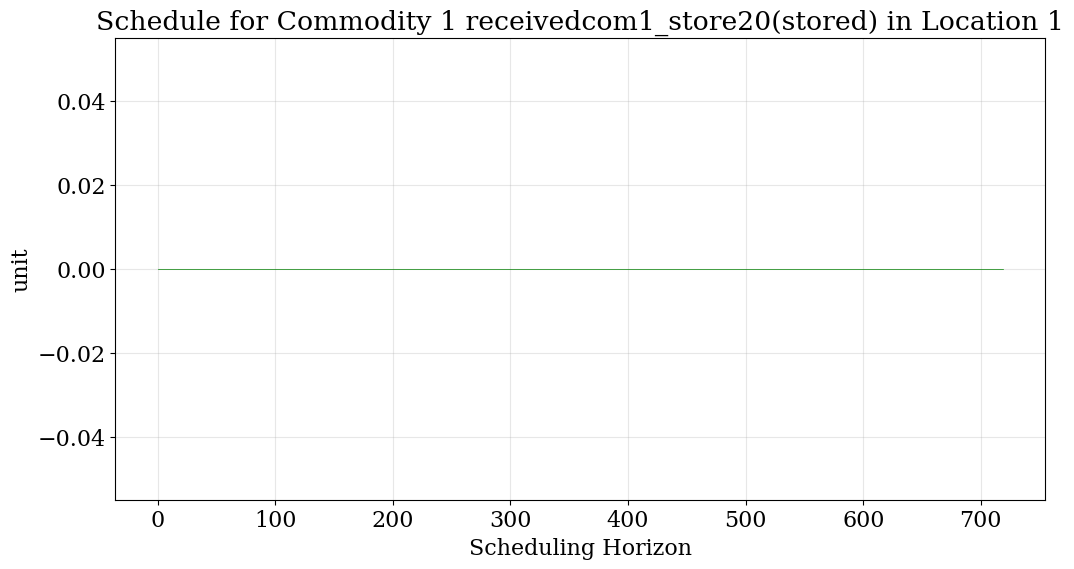

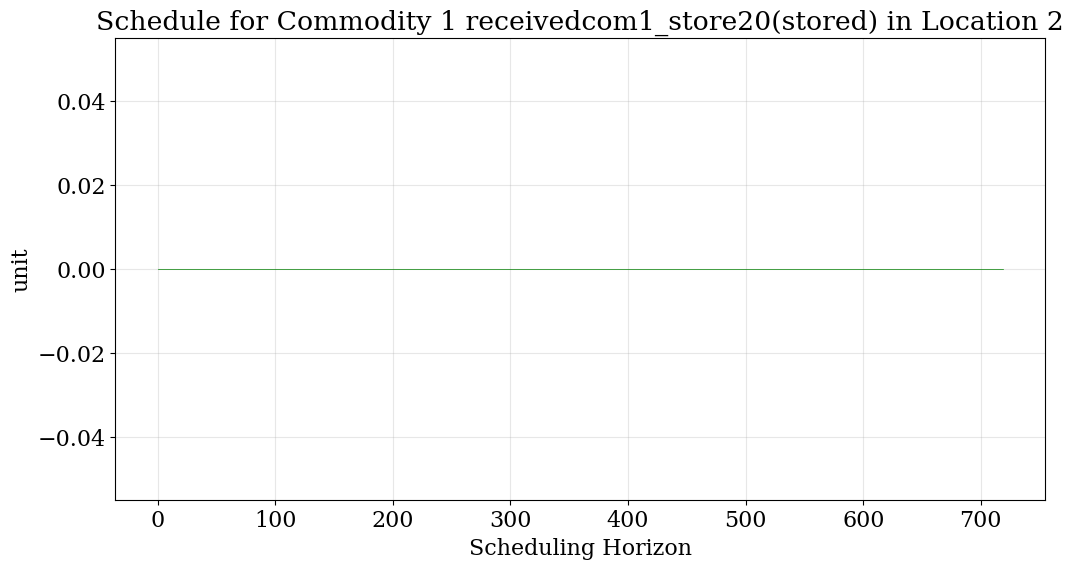

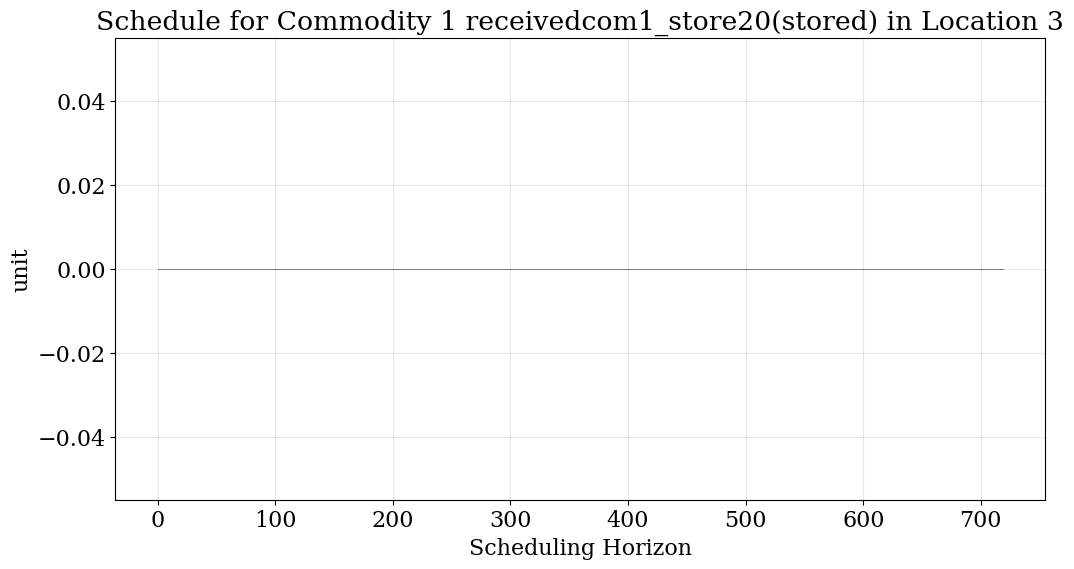

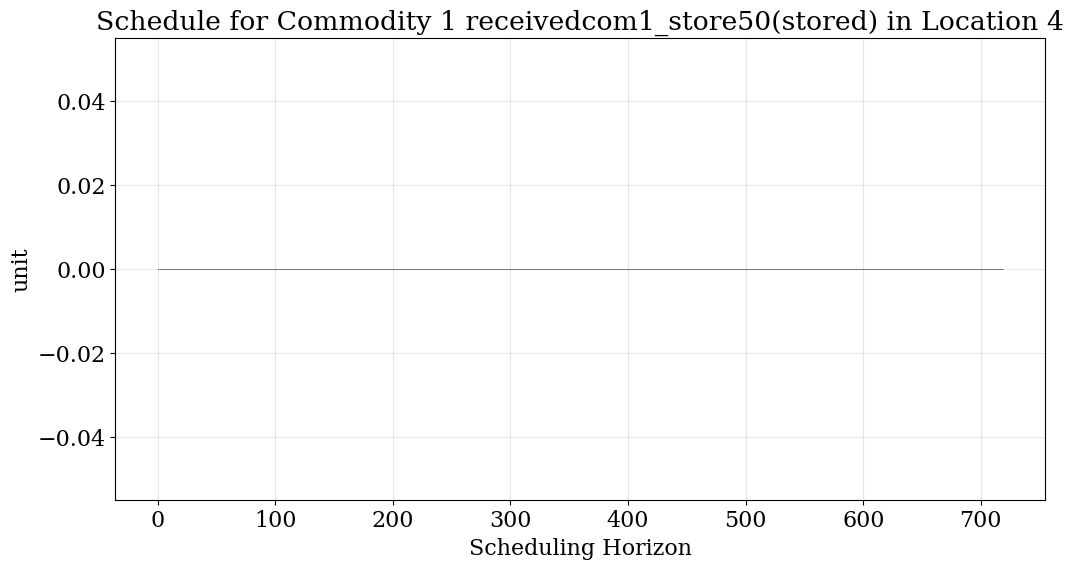

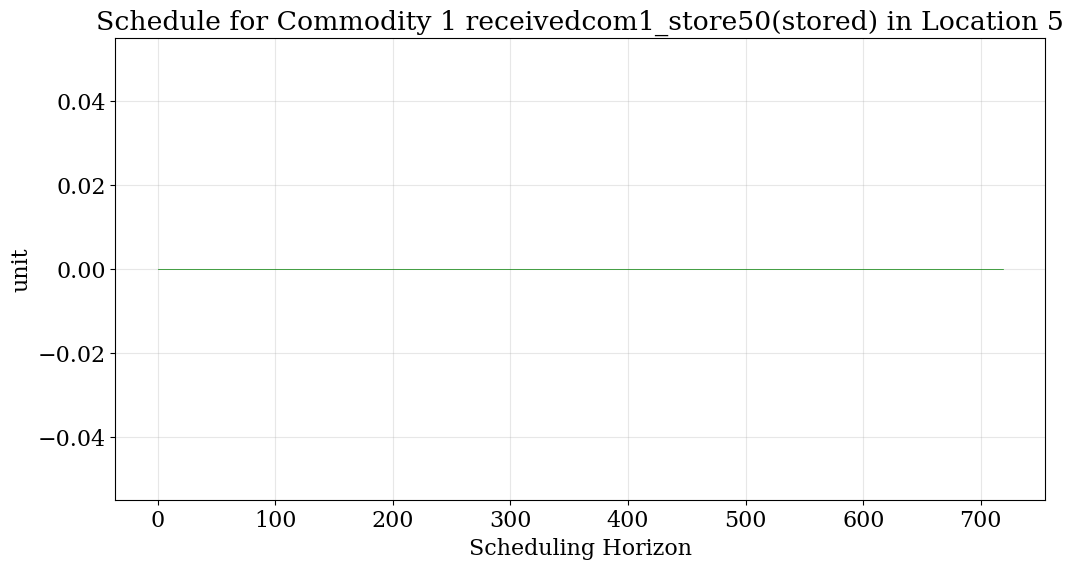

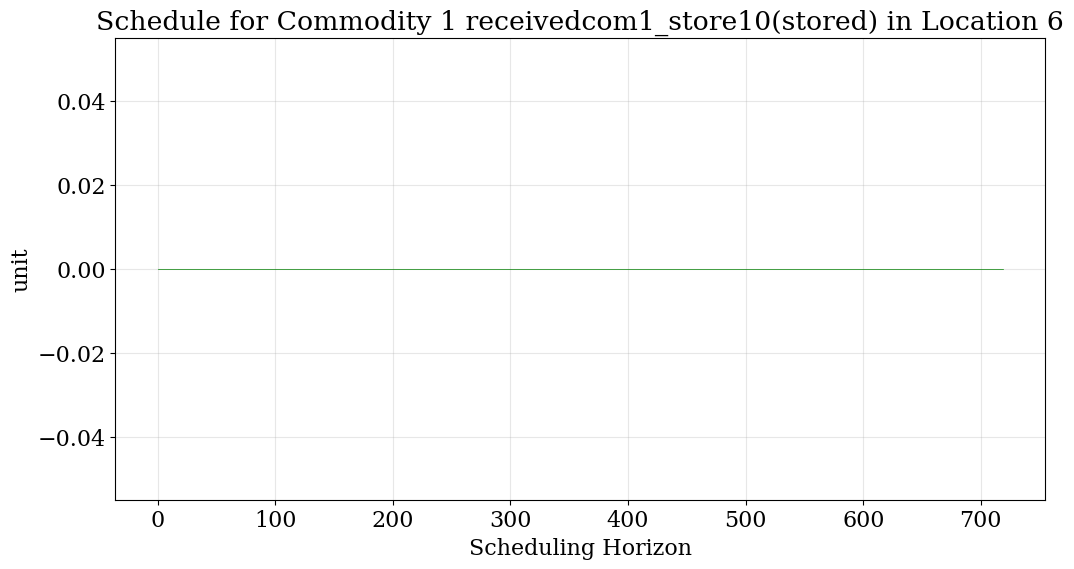

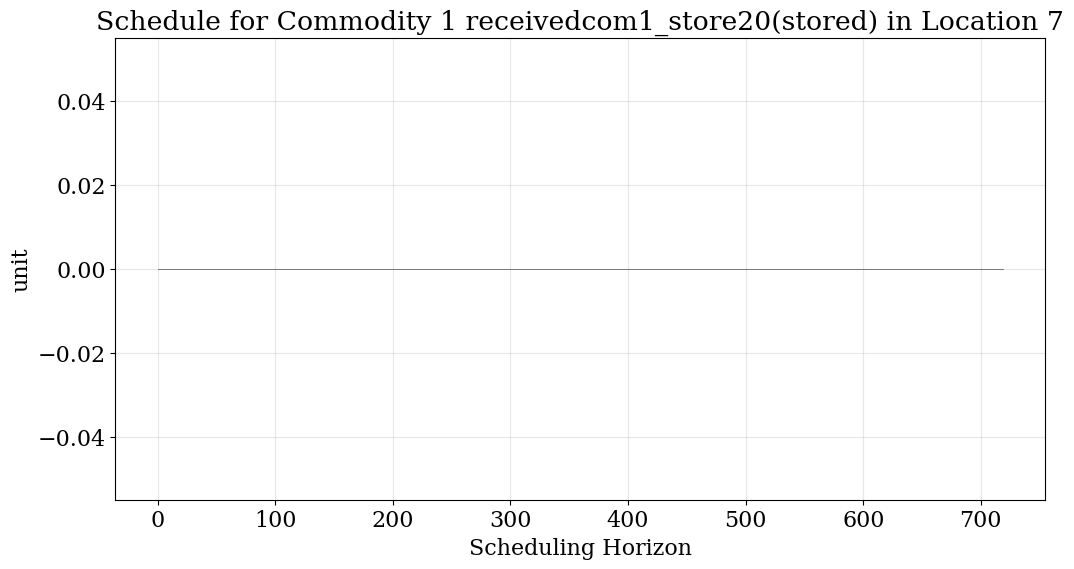

In [18]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

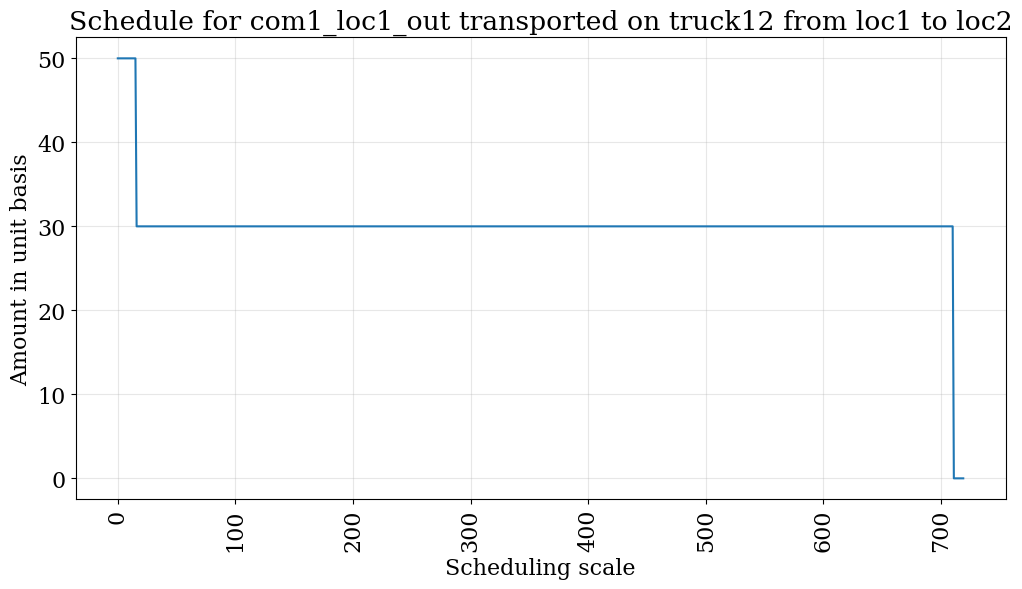

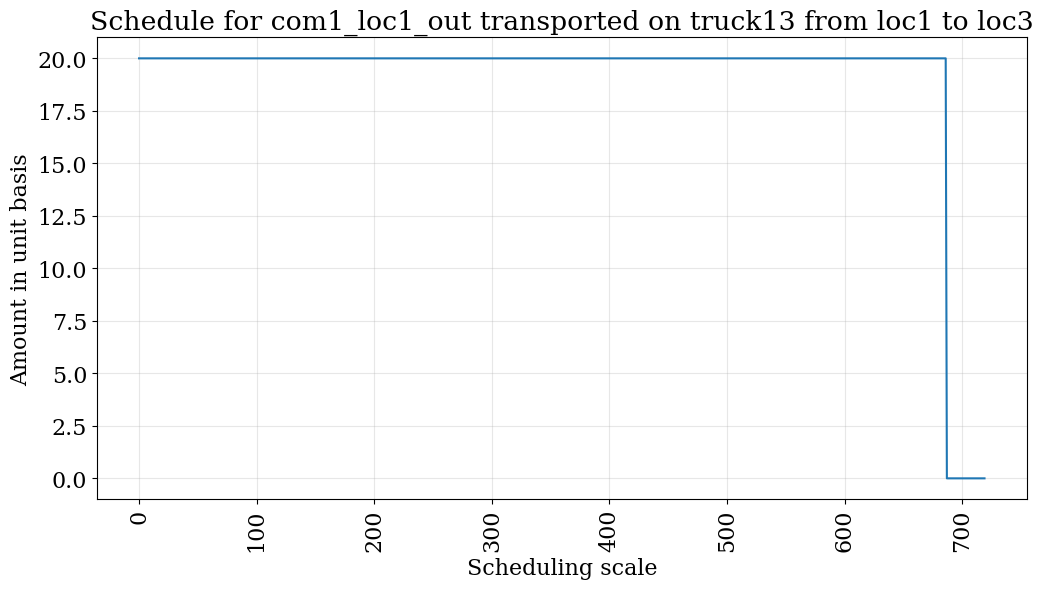

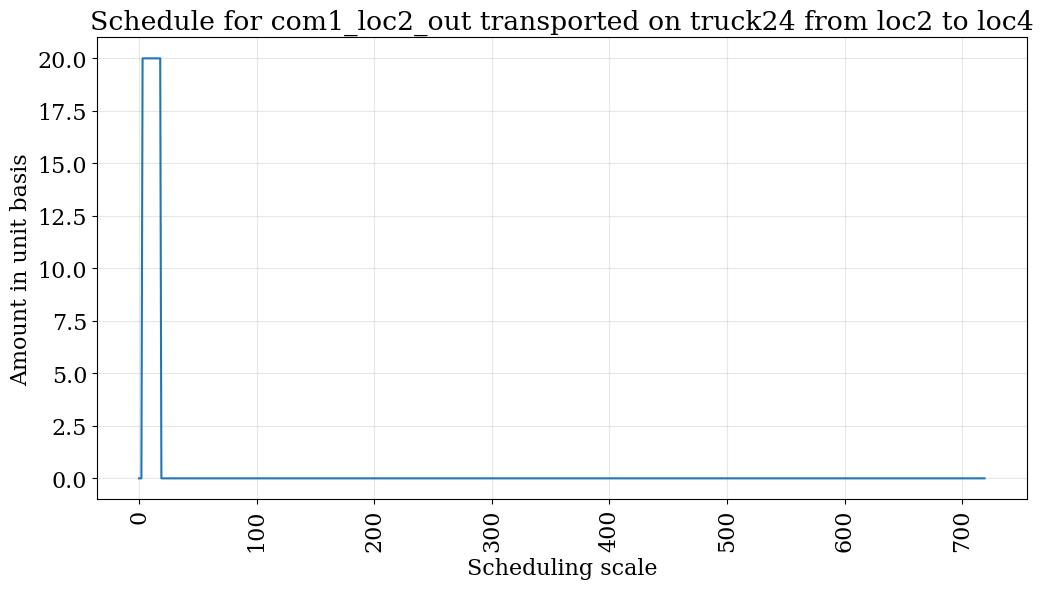

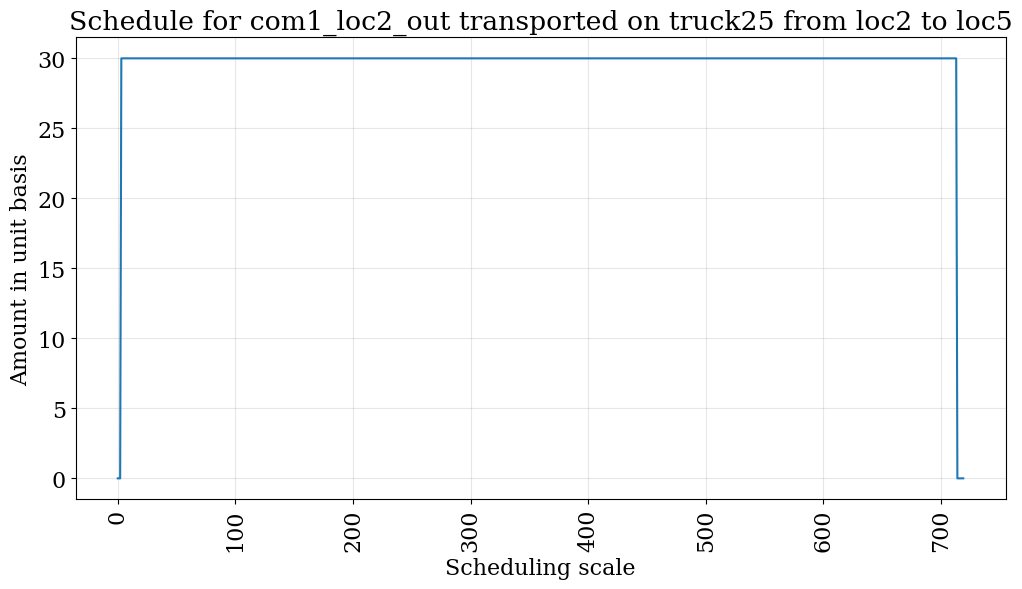

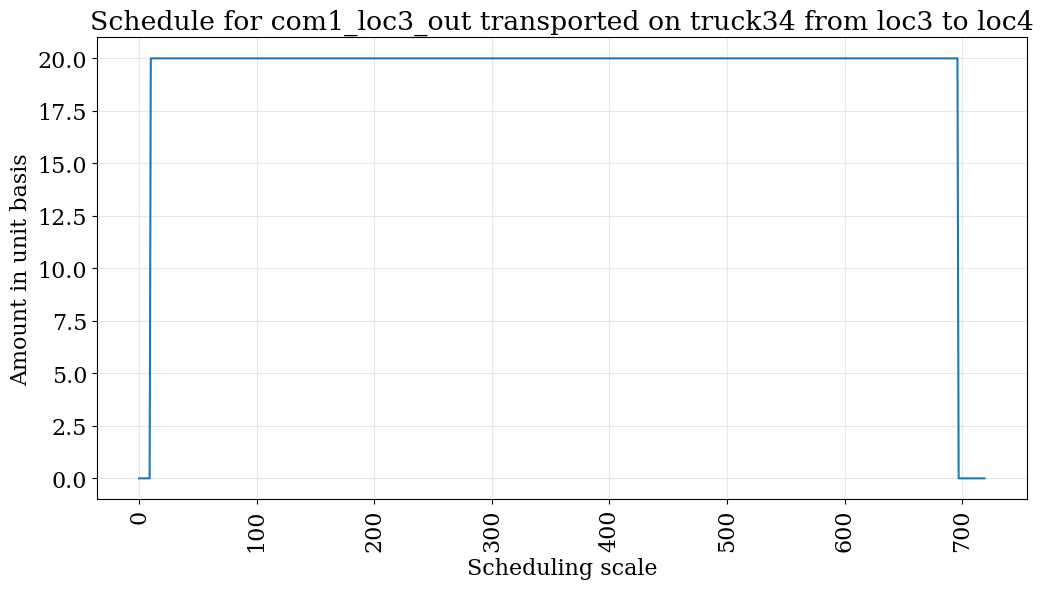

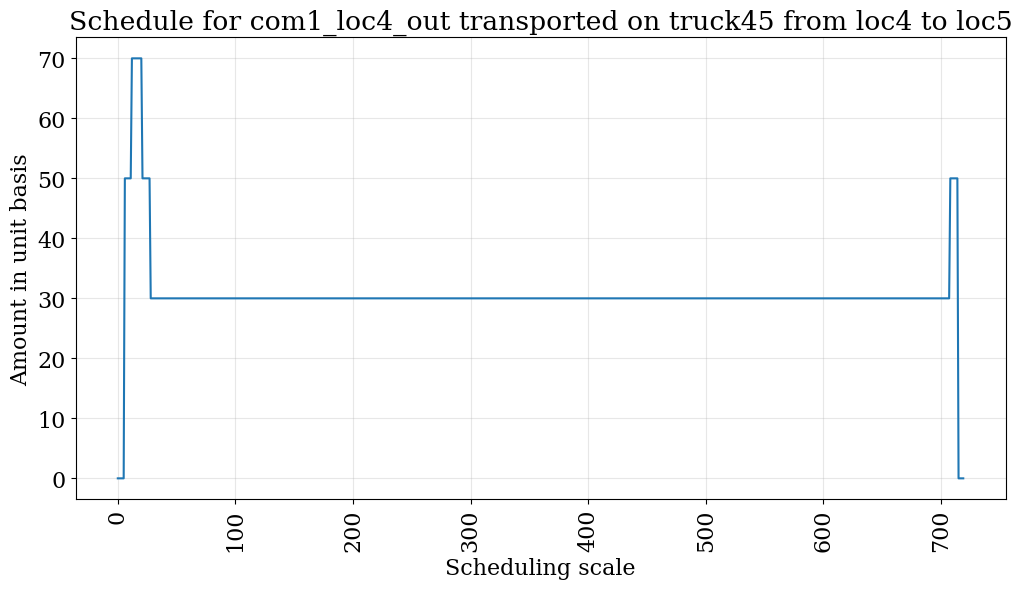

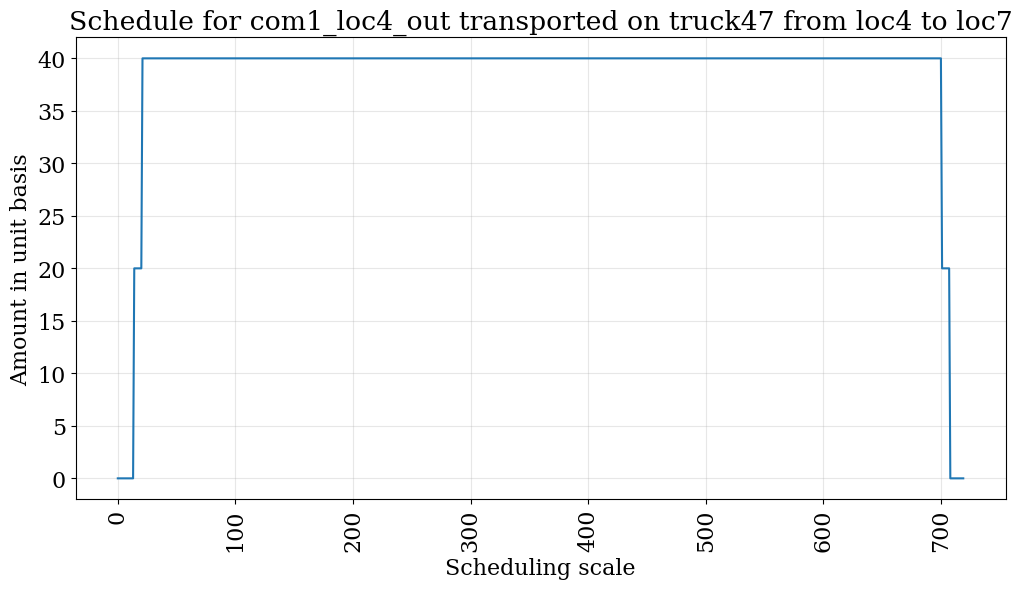

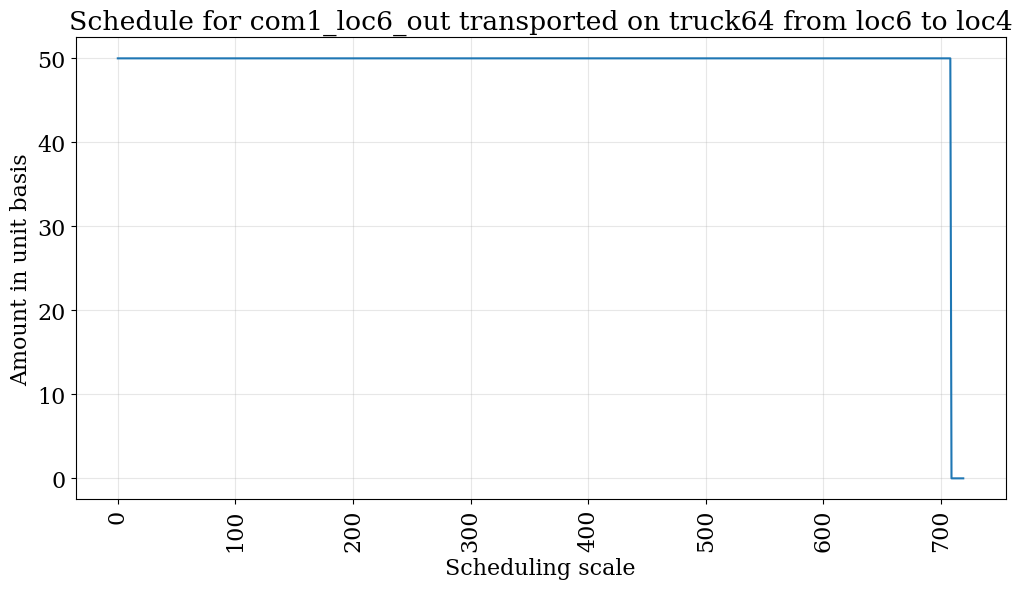

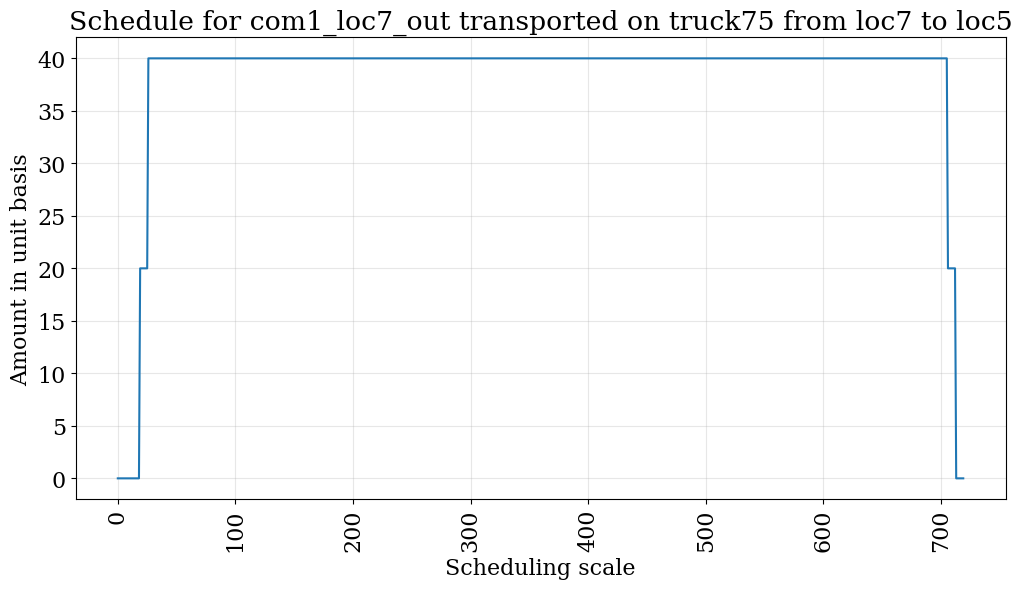

In [19]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck12', resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck13', resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc4', transport='truck24', resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck25', resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck34', resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck45', resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck47', resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck64', resource='com1_loc6_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck75', resource='com1_loc7_out')

In [20]:
# plot_results.transport(results=results_mincost, source='loc2', sink='loc1', transport='truck50_21',
#                        resource='com1_loc2_out')
# plot_results.transport(results=results_mincost, source='loc3', sink='loc1', transport='truck30_31',
#                        resource='com1_loc3_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc2', transport='truck50_42',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc5', sink='loc2', transport='truck30_52',
#                        resource='com1_loc5_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc3', transport='truck20_43',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc5', sink='loc4', transport='truck100_54',
#                        resource='com1_loc5_out')
# plot_results.transport(results=results_mincost, source='loc7', sink='loc4', transport='truck40_74',
#                        resource='com1_loc7_out')
# plot_results.transport(results=results_mincost, source='loc4', sink='loc6', transport='truck50_46',
#                        resource='com1_loc4_out')
# plot_results.transport(results=results_mincost, source='loc5', sink='loc7', transport='truck40_57',
#                        resource='com1_loc5_out')

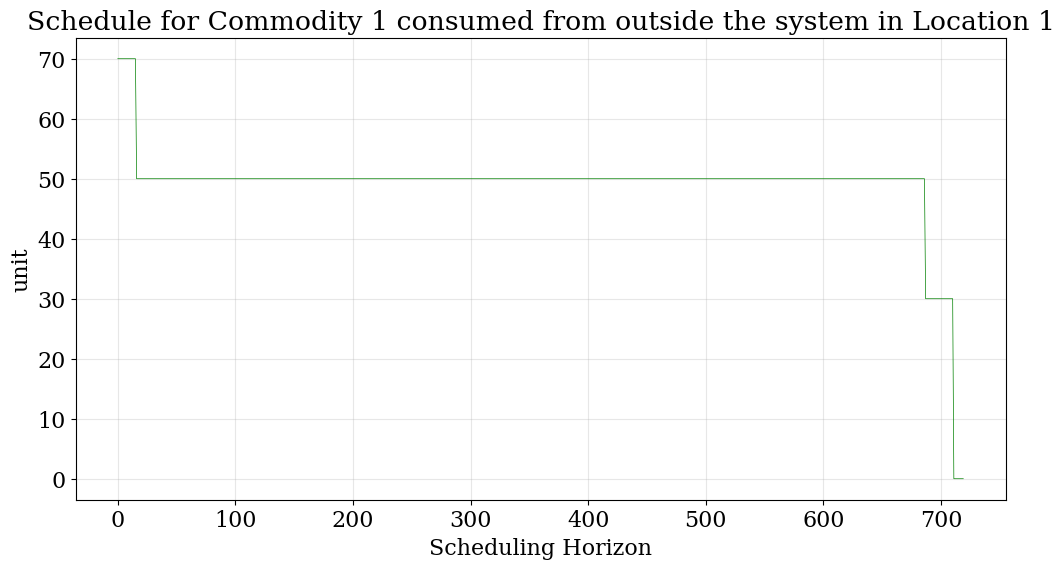

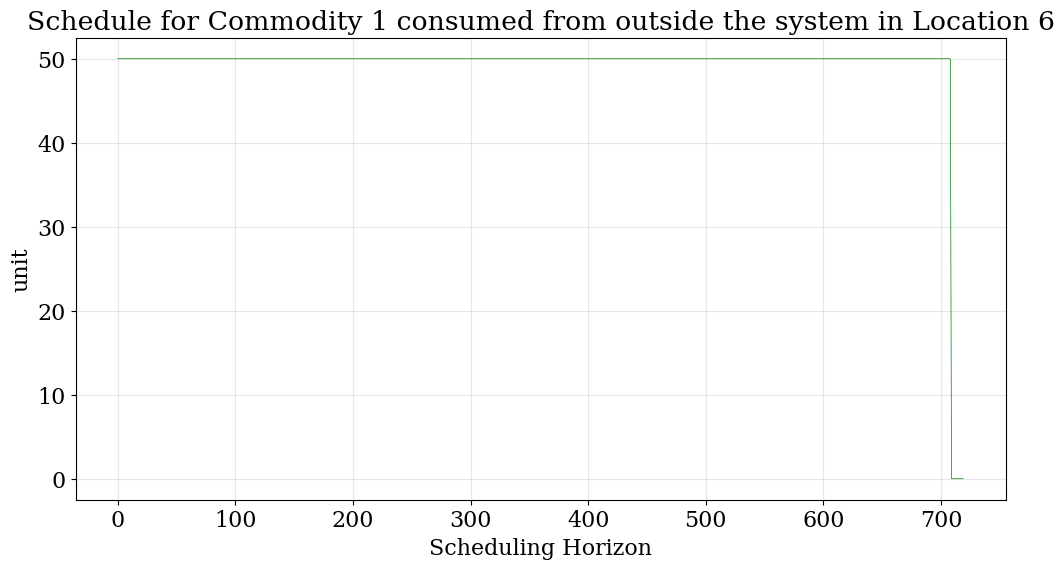

In [21]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')